# Facebook Prophet

🔍 Что такое Prophet?

Facebook Prophet — это библиотека от Meta (Facebook), специально созданная для прогнозирования временных рядов, особенно тех, которые имеют:

    Ярко выраженную сезонность

    Праздничные всплески

    Тренды (рост или падение)

⚙️ Под капотом Prophet работает как аддитивная модель:
y(t)=g(t)+s(t)+h(t)+εt

где:

    g(t) — тренд

    s(t) — сезонность

    h(t) — влияние праздников (по желанию)

    εt​ — шум (ошибка)

In [6]:
!pip install prophet
!pip install sklearn.metrics
!pip install numpy


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Could not find a version that satisfies the requirement sklearn.metrics (from versions: none)

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for sklearn.metrics



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


C:\Users\OsenD\AppData\Local\Temp\ipykernel_21364\307005278.py:7: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv('household_power_consumption.csv', sep=';', parse_dates=[[0, 1]],
C:\Users\OsenD\AppData\Local\Temp\ipykernel_21364\307005278.py:7: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('household_power_consumption.csv', sep=';', parse_dates=[[0, 1]],
C:\Users\OsenD\AppData\Local\Temp\ipykernel_21364\307005278.py:7: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('household_powe

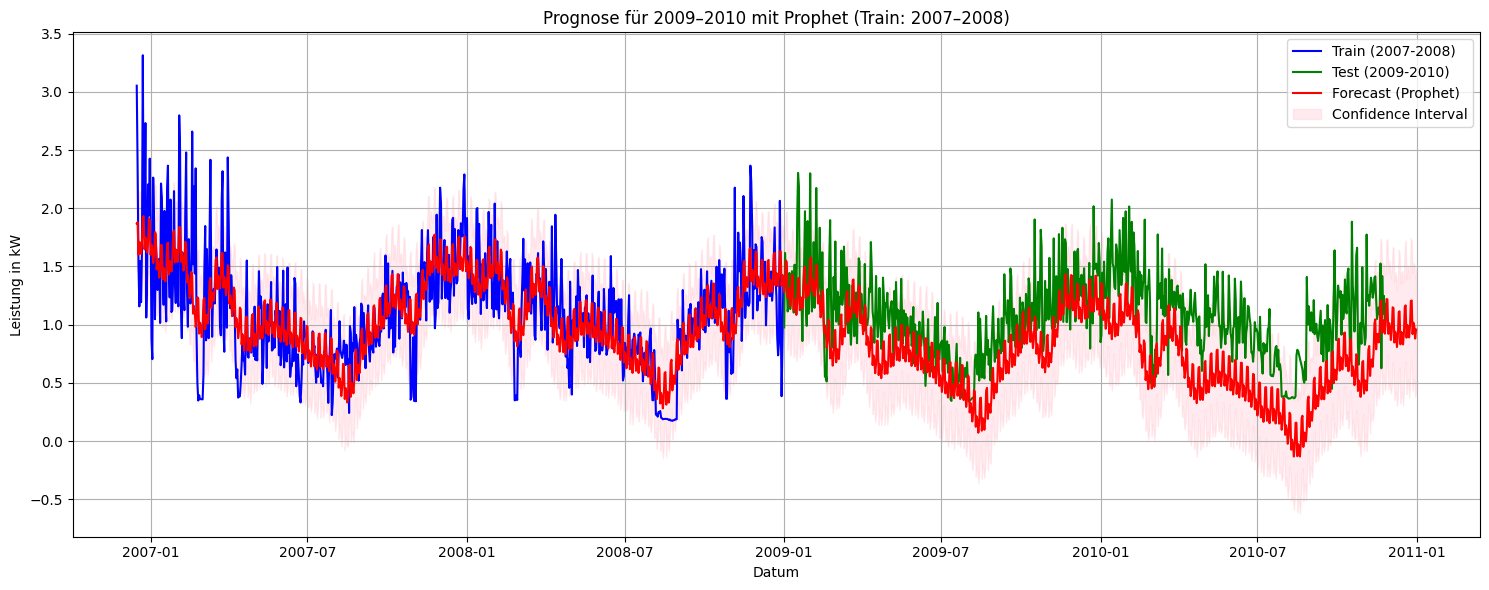

In [7]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Загрузка и обработка
df = pd.read_csv('household_power_consumption.csv', sep=';', parse_dates=[[0, 1]],
                 na_values='?', infer_datetime_format=True, low_memory=False)
df.rename(columns={'Date_Time': 'Datetime'}, inplace=True)
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%d/%m/%Y %H:%M:%S', errors='coerce')
df.set_index('Datetime', inplace=True)
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
daily = df[['Global_active_power']].resample('D').mean().interpolate()

# Формат Prophet
prophet_df = daily.reset_index()
prophet_df.columns = ['ds', 'y']

# Выделим train (2006–2008) и test (2009–2010)
train = prophet_df[(prophet_df['ds'] >= '2006-01-01') & (prophet_df['ds'] <= '2008-12-31')]
test = prophet_df[(prophet_df['ds'] >= '2009-01-01') & (prophet_df['ds'] <= '2010-11-26')]

# Обучение модели Prophet
model = Prophet()
model.fit(train)

# Создание future (на 2 года вперёд = 730 дней)
future = model.make_future_dataframe(periods=730)
forecast = model.predict(future)

# График: сравнение train, test и прогноза
plt.figure(figsize=(15,6))
plt.plot(train['ds'], train['y'], label='Train (2007-2008)', color='blue')
plt.plot(test['ds'], test['y'], label='Test (2009-2010)', color='green')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast (Prophet)', color='red')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], 
                 color='pink', alpha=0.3, label='Confidence Interval')
plt.title('Prognose für 2009–2010 mit Prophet (Train: 2007–2008)')
plt.xlabel('Datum')
plt.ylabel('Leistung in kW')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




## 2. MAE, RMSE, MAPE

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def compute_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, mape

# Оставим только прогнозные значения за период теста (2009–2010)
forecast_test = forecast.set_index('ds').loc['2009-01-01':'2010-11-26']
test_daily = test.copy()
if 'ds' in test_daily.columns:
	test_daily = test_daily.set_index('ds')
      
forecast_test = forecast_test.loc[test_daily.index]
# Убедимся, что размеры совпадают
assert len(forecast_test) == len(test)

mae_p, rmse_p, mape_p = compute_metrics(test_daily['y'].values, forecast_test['yhat'].values)

print(f"[Prophet] MAE: {mae_p:.3f}, RMSE: {rmse_p:.3f}, MAPE: {mape_p:.2f}%")



[Prophet] MAE: 0.365, RMSE: 0.438, MAPE: 35.68%
